# Individual project - 3029121

### Description of the task:

This dataset is composed of 1100 samples with 31 features each. The first column
in the dataset represents the label. There are 5 labels. The remaining columns
are numeric features, except for the last column which is categorical (with 3
categories).

Your task is the following: you should compare the performance of a Multi-Layer
Perceptron (implemented by sklearn.neural_network.MLPClassifier) with that of a
Random Forest (implemented by sklearn.ensemble.ExtraTreesClassifier). Try to
optimize both algorithms' parameters and determine which one is best for this
dataset. At the end of the analysis, you should have chosen an algorithm and its
optimal set of parameters: write this choice explicitly in the conclusions of
your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).


### The notebook is divided in:
Data Exploration:
- statistics about the features
- scatter plots for the features
- correlation matrix
        
Feature Engineering:
- PCA
- Modification for PCA
- Feature Generation
        
Multilayer Perceptron:
- apply with different preprocessing
        
Random forest:
- features importances
- hyperparameter tuning
        
SVM:
- Hyperparameter optimization  

Evaluation
- Confusion matrix
- Receiver operating characteristic (ROC)


In this notebook, I will use classification accuracy as the primary evaluation criterion.

## Import python package

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import export_graphviz

Loading data:

In [2]:
df = pd.read_csv('mldata_0000123456.csv') # Load the csv in a pandas dataframe
df_backup = df.copy() # Create a backup copy of the DataFrame

In [3]:
pd.set_option('display.max_columns', None)

## Functions to use later


Training and testing on the same data is a methodological mistake. 

To avoid overfitting, it is reasonable to split the dataset into Training set and Test test, it is common to choose 70% and 30% as proportion and we choose num_test = 220 and num_train 880, which is almost the same.

In [4]:
all_train = 1100

Standardization of datasets is a common requirement for neural networks; they might behave badly if the individual features do not more or less look like standard normally distributed data: gaussian with zero mean and unit variance.  

So we define a function for this purpose.

In [5]:
class parse_data:
    def __init__(self, num_train = 770, num_test = 330, seed = 246232, normalize = True, n_components = 0):
        
        # in order to randomize the rows
        np.random.seed(seed)
        perm = np.random.permutation(all_train)
        
        i_train = perm[:num_train]
        i_valid = perm[num_train:num_train+num_test]

        train_data = features_1[i_train,:]
        train_target = target[i_train]
        test_data = features_1[i_valid,:]
        test_target = target[i_valid]
        
        if normalize:
            train_data_1 = (train_data - train_data.mean())/ train_data.std()
            test_data_1 = (test_data - train_data.mean())/ train_data.std()
        
        else:
            train_data_1, test_data_1 = train_data, test_data
    
        if n_components > 0:
            pca = PCA(n_components = n_components)
            pca.fit(train_data)
            X = pca.transform(train_data_1)
            vX = pca.transform(test_data_1)
        else:
            X, vX = train_data_1, test_data_1
            
        nc = X.shape[1]
        print('nc=%i' % X.shape[1])
        
        self.perm = perm
        self.X, self.y = train_data_1, train_target
        self.vX, self.vy = test_data_1, test_target
        
    def train(self):
        return self.X, self.y
    
    def test(self):
        return self.vX, self.vy

In [6]:
class parse_data_kpca:
    def __init__(self, num_train = 770, num_test = 330, seed = 246232, n_components = 0):
        
        np.random.seed(seed)
        perm = np.random.permutation(all_train)

        i_train = perm[:num_train]
        i_valid = perm[num_train:num_train+num_test]
        
        
        train_data = features_1[i_train,:]
        train_target = target[i_train]
        test_data = features_1[i_valid,:]
        test_target = target[i_valid]
                        
        train_data_1 = (train_data - train_data.mean())/ train_data.std()
        # fit only on training data because I read it here: https://sebastianraschka.com/faq/docs/scale-training-test.html
        test_data_1 = (test_data - train_data.mean())/ train_data.std()

        if n_components > 0:
            kpca = KernelPCA(n_components = n_components, kernel = 'rbf', gamma = 15)
            X = kpca.fit_transform(train_data_1)
            vX = kpca.transform(test_data_1)
        else:
            X, vX = train_data_1, test_data_1
        
        nc = X.shape[1]
        print('nc=%i' % X.shape[1])
        
        self.perm = perm
        self.X, self.y = X, train_target
        self.vX, self.vy = vX, test_target
        self.kpca = pca if n_components > 0 else None
    
    def train(self):
        return self.X, self.y
    
    def test(self):
        return self.vX, self.vy

In [7]:
d = {} # a dictonary to collect the models validation scores

# Data exploration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 33 columns):
Unnamed: 0        1100 non-null int64
label             1100 non-null int64
num.feature 1     1100 non-null float64
num.feature 2     1100 non-null float64
num.feature 3     1100 non-null float64
num.feature 4     1100 non-null float64
num.feature 5     1100 non-null float64
num.feature 6     1100 non-null float64
num.feature 7     1100 non-null float64
num.feature 8     1100 non-null float64
num.feature 9     1100 non-null float64
num.feature 10    1100 non-null float64
num.feature 11    1100 non-null float64
num.feature 12    1100 non-null float64
num.feature 13    1100 non-null float64
num.feature 14    1100 non-null float64
num.feature 15    1100 non-null float64
num.feature 16    1100 non-null float64
num.feature 17    1100 non-null float64
num.feature 18    1100 non-null float64
num.feature 19    1100 non-null float64
num.feature 20    1100 non-null float64
num.feature 21   

As we can see there are 33 columns, of which one is the label, 30 are the numerical features and one categorical.
All the columns have no missing values so we don't need to perform data imputation or other tecniques to deal with missing values. 

In [9]:
del df['Unnamed: 0'] # since it is of no use

In [10]:
df.describe()

,label,num.feature 1,num.feature 2,num.feature 3,num.feature 4,num.feature 5,num.feature 6,num.feature 7,num.feature 8,num.feature 9,num.feature 10,num.feature 11,num.feature 12,num.feature 13,num.feature 14,num.feature 15,num.feature 16,num.feature 17,num.feature 18,num.feature 19,num.feature 20,num.feature 21,num.feature 22,num.feature 23,num.feature 24,num.feature 25,num.feature 26,num.feature 27,num.feature 28,num.feature 29,num.feature 30
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,1.968182,-0.265888,0.143744,0.168060,0.111098,0.085971,0.114622,-0.314998,0.108677,-0.356370,0.068793,0.279613,0.106471,0.108624,0.083987,0.106775,-0.028918,-0.277428,0.124572,0.079560,0.080086,0.561300,0.061954,0.078599,0.099026,0.101790,0.106174,0.191949,0.278262,0.070834,0.085502
std,1.392782,1.927995,2.110047,0.994245,0.999399,0.967355,0.989715,3.726347,0.977305,2.053343,1.000827,2.060929,0.976164,1.005654,0.992271,1.003802,2.046352,1.915397,1.005362,1.031731,1.011924,1.891867,1.012060,1.011362,0.982710,1.036216,1.002602,1.978776,2.023796,1.022819,1.037606
min,0.000000,-5.572280,-7.023843,-3.205283,-3.195557,-3.154411,-3.763901,-15.566585,-3.392629,-6.606856,-3.435418,-6.040327,-3.521952,-2.898262,-3.255320,-3.228066,-6.837165,-6.464224,-2.984971,-2.986246,-2.813661,-6.164942,-3.150187,-3.135188,-3.232895,-3.178913,-3.131281,-6.995629,-5.765517,-3.706457,-2.578069
25%,1.000000,-1.603757,-1.299263,-0.486339,-0.540043,-0.532857,-0.551483,-2.847479,-0.595480,-1.786436,-0.609737,-1.126914,-0.538061,-0.578345,-0.557922,-0.562922,-1.466709,-1.580629,-0.553609,-0.610843,-0.605847,-0.740940,-0.637173,-0.580319,-0.554056,-0.603547,-0.531677,-1.111803,-1.155579,-0.657053,-0.655928
50%,2.000000,-0.305901,0.046804,0.177357,0.129507,0.079690,0.081924,-0.464851,0.128555,-0.388865,0.080394,0.311381,0.110153,0.101047,0.076074,0.105941,-0.079140,-0.272036,0.097023,0.095325,0.069360,0.714927,0.091345,0.065125,0.122068,0.064667,0.107351,0.097860,0.298218,0.119686,0.083158
75%,3.000000,1.008282,1.622987,0.865906,0.765034,0.717995,0.754018,2.195764,0.772160,1.059808,0.745078,1.716051,0.721152,0.801161,0.820449,0.758120,1.310421,1.042137,0.776607,0.771807,0.761197,1.917175,0.759491,0.757354,0.753236,0.776072,0.750397,1.516155,1.704388,0.772094,0.798690
max,4.000000,5.860654,8.070785,3.185651,3.904119,3.403965,3.200272,11.816840,2.996658,6.721017,3.496736,7.853763,3.034492,3.342145,2.839441,3.328024,7.110147,6.137261,3.753506,3.239119,3.599787,6.333000,3.506882,3.609617,3.585641,3.671660,3.124180,6.470071,6.343299,3.342416,3.300643


The table above shows some statistics about all the features, grouped by label. 
Given that the features have different mean and standard deviation I should standardize them, but later.

We visualize the histograms of the columns

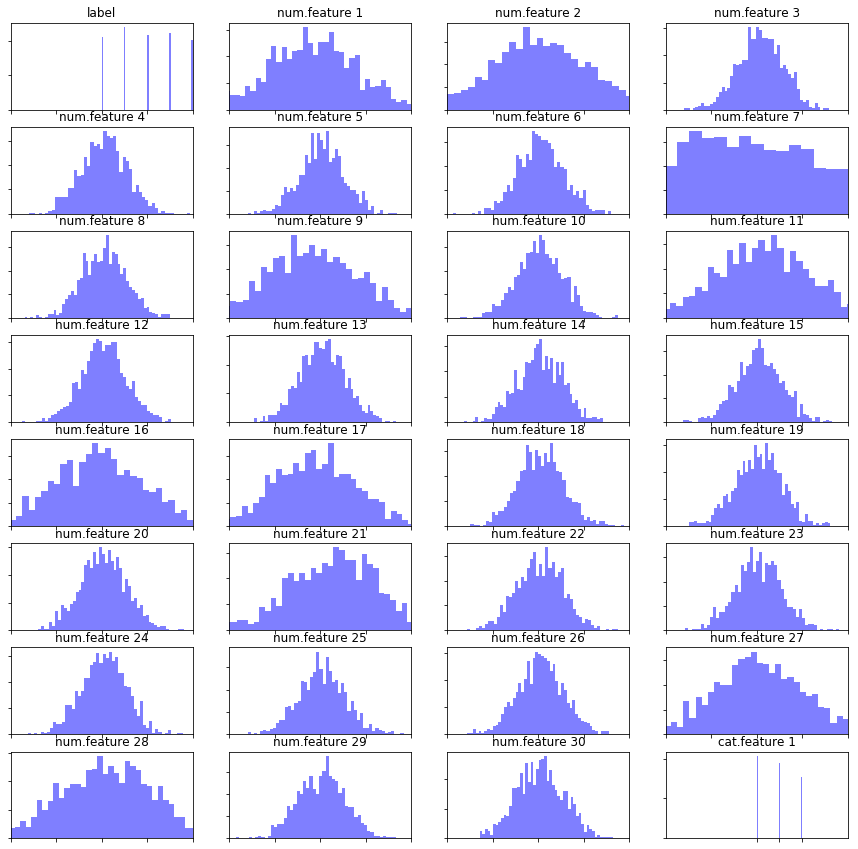

In [11]:
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (15,15))
axes = axes.flatten()

columns = df.columns
for i in range(len(columns)):
  axes[i].hist(df[columns[i]], bins = 50, facecolor = 'b', alpha = 0.5)
  axes[i].set_title(columns[i])
  axes[i].set_xlim([-4., +4.])
  plt.setp(axes[i].get_xticklabels(), visible = False) 
  plt.setp(axes[i].get_yticklabels(), visible = False)

Each numerical feature is more or less normally distributed. the only categorical feature we have sees a little skewed to the right

In [12]:
df['cat.feature 1'].value_counts()

A    415
B    376
C    309
Name: cat.feature 1, dtype: int64

true

In [13]:
# look for missing values
df.isnull().any()

label             False
num.feature 1     False
num.feature 2     False
num.feature 3     False
num.feature 4     False
num.feature 5     False
num.feature 6     False
num.feature 7     False
num.feature 8     False
num.feature 9     False
num.feature 10    False
num.feature 11    False
num.feature 12    False
num.feature 13    False
num.feature 14    False
num.feature 15    False
num.feature 16    False
num.feature 17    False
num.feature 18    False
num.feature 19    False
num.feature 20    False
num.feature 21    False
num.feature 22    False
num.feature 23    False
num.feature 24    False
num.feature 25    False
num.feature 26    False
num.feature 27    False
num.feature 28    False
num.feature 29    False
num.feature 30    False
cat.feature 1     False
dtype: bool

The data is clean with no missing values or outliers.  
I'll build models with different algorithms and see how they score. I'll take the highest scoring models continue forward with those.

### Feature engineering

We have 1 column with categorical data.

In [14]:
cat_features = list(df.select_dtypes(include=['object']).columns)

We should transform the categorial feature into numerical (using one-hot method) so that we can pass it to the classifier:

In [15]:
one_hot = pd.concat([pd.get_dummies(df[i],prefix = i) for i in cat_features], axis = 1)

#concatenate df and the new cat
df_new = pd.concat((df,one_hot), axis = 1)
categories = df_new['cat.feature 1']

In [16]:
features = df_new[['num.feature 1','num.feature 2',
       'num.feature 3', 'num.feature 4', 'num.feature 5', 'num.feature 6',
       'num.feature 7', 'num.feature 8', 'num.feature 9', 'num.feature 10',
       'num.feature 11', 'num.feature 12', 'num.feature 13', 'num.feature 14',
       'num.feature 15', 'num.feature 16', 'num.feature 17', 'num.feature 18',
       'num.feature 19', 'num.feature 20', 'num.feature 21', 'num.feature 22',
       'num.feature 23', 'num.feature 24', 'num.feature 25', 'num.feature 26',
       'num.feature 27', 'num.feature 28', 'num.feature 29', 'num.feature 30',
       'cat.feature 1_A', 'cat.feature 1_B', 'cat.feature 1_C']]
features_1 = np.array(features)

target = np.array(df_new['label'].values)
target_1 = df_new['label'].values


Many models benefit from reduced predictors, we use correlation heatmaps to identify them. 


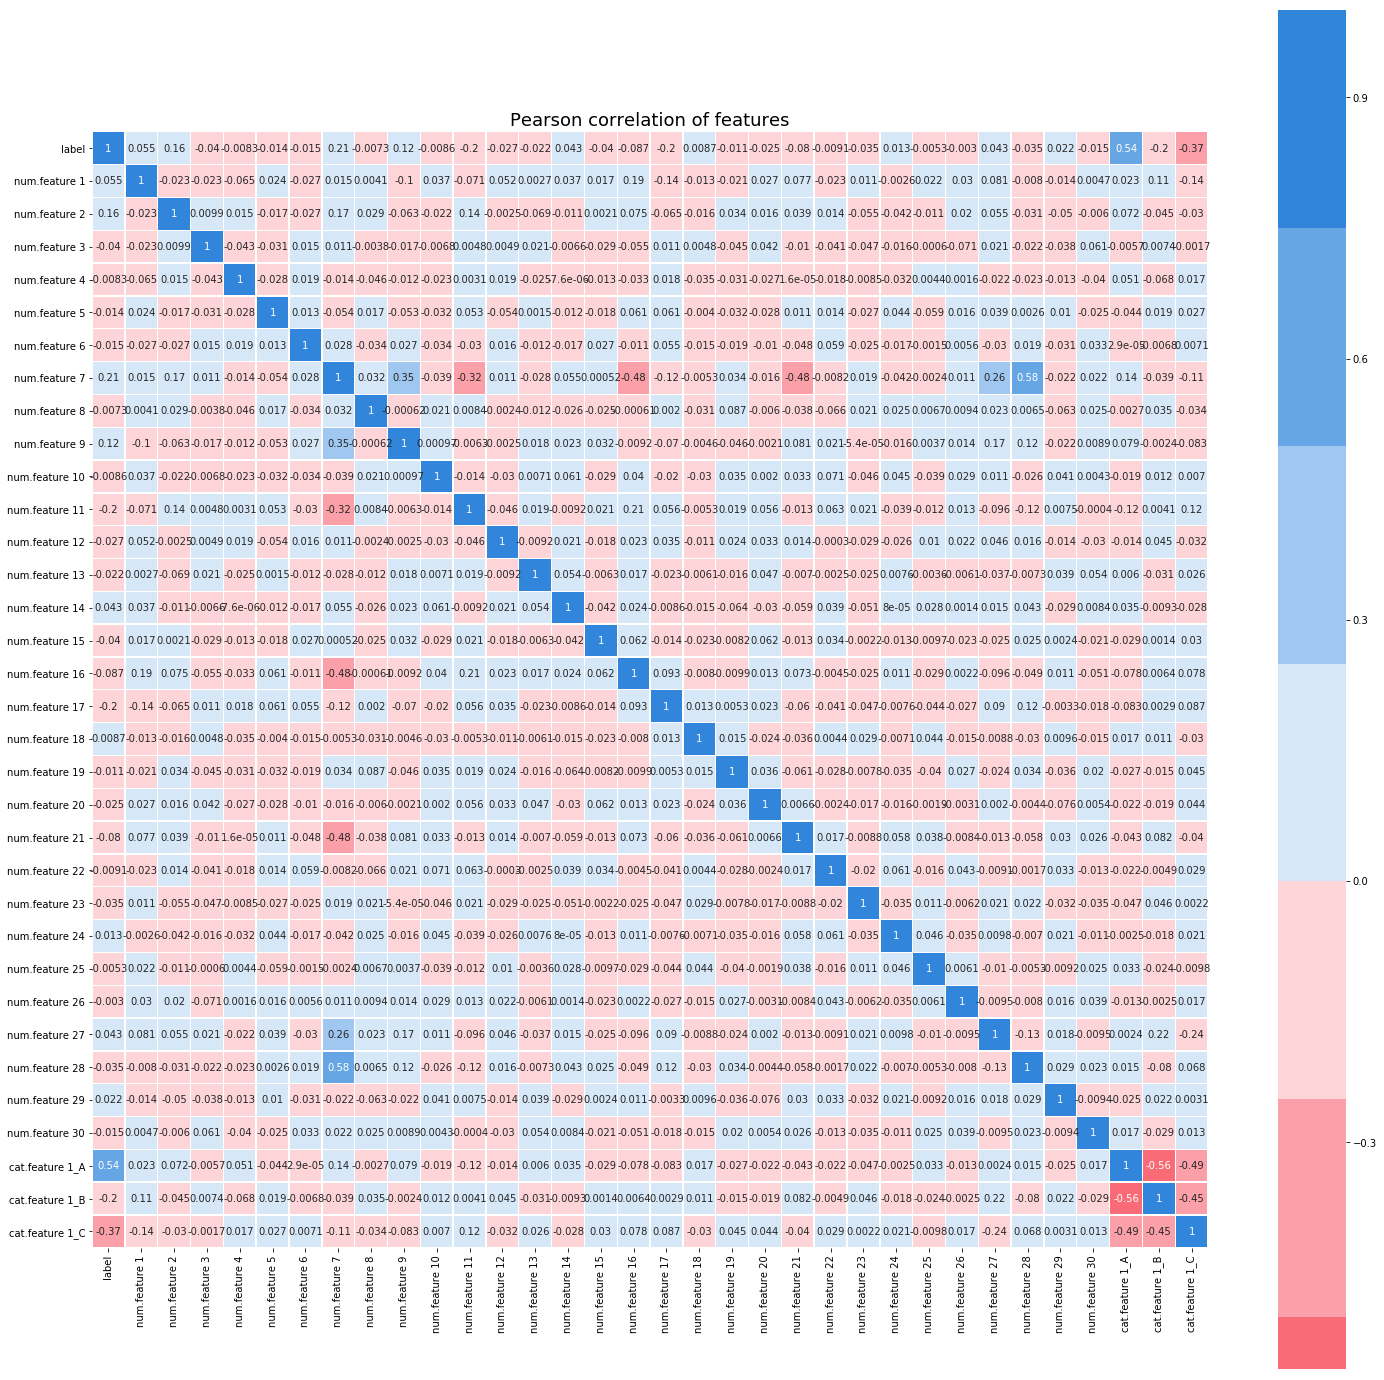

In [17]:
cmap = sns.diverging_palette(10, 250, s=90, l=55, n=8)
plt.figure(figsize = (25,25))
plt.title('Pearson correlation of features', y = 1, size = 18)
sns.heatmap(df_new.corr(),linewidths = 0.4 ,vmax = 1, center = 0, square = True, 
            cmap = cmap, linecolor = 'white', annot = True);

From the correlation plot, we can see that almost all the features display zero or no correlation to one another. 
I list all the features which have positive correlation:   
-. num.feature 7 and num.feature 28 have 0.58 correlation  
-. num.feature 7 and num.feature 9 have 0.35 correlation  
-. the others are too close to 0...  
I also list all the features which have negative correlation:   
-. num.feature 7 and num.feature 11 have -0.32 correlation  
-. num.feature 7 and num.feature 16 have -0.48 correlation  
-. num.feature 7 and num.feature 21 have -0.48 correlation  


Since there are no variables that are highly correlated, we cannot simplify the model using feature selection.

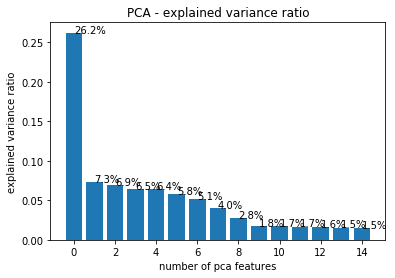

In [18]:
pca = PCA(n_components = 15)
features_r = pca.fit(features).transform(features)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
for a, b in zip(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_):
    plt.text(a, b, str(np.round(b, 3) * 100) + "%")
    
plt.title("PCA - explained variance ratio")
plt.ylabel('explained variance ratio')
plt.xlabel('number of pca features')
plt.show()

After the 8th feature, the explained variance drop to less than 2%

## More data exploration

In [19]:
tab1 = pd.crosstab(index = categories, columns = df['label'])
tab1

label,0,1,2,3,4
cat.feature 1,,,,,
A,2,58,61,138,156
B,23,157,157,32,7
C,188,26,0,54,41


Text(0.5,0,'lab')

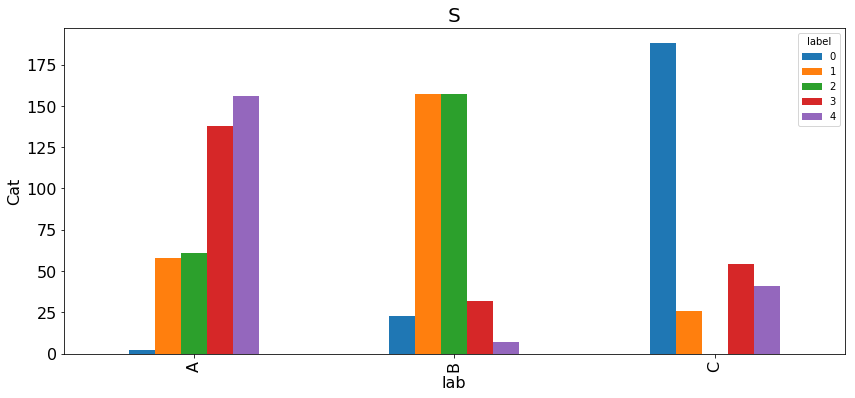

In [20]:
tab1.plot.bar(fontsize=16, figsize=(14,6))
plt.title('S', fontsize=20)
plt.ylabel('Cat', fontsize=16)
plt.xlabel('lab', fontsize=16)

Each category has a different combination of labels.

## Training a MLP

Summary of MLP:  
MLP is a supervised machine learning algorithm for regression or classification. 
MLP has the ability to learn nonlinear models (since in our model the relationship between labels and features might be non-linear). 
MLP is sensitive to unscaled features, thus it might be important to scale the feature - [0, 1], hence both the training and testing sets will be standardized.  
MLPClassifier in sklearn uses parameter alpha for regularization (L2 regularization), which is used for penalizing the weights, hence, ensuring that the weights are as small as possible.   
GridsearchCV can be used to obtain the best value of alpha, values ranging from 1e-6 to 1e-1 (log scale) are mostly used.  
In Sklearn, the solver for weight optimization could be any of 'lbfgs', 'sgd', or 'adam'. SGD refers to stochastic gradient descent, it performs better than the other two.   
It would also be possible to use other solvers, but they have do be coded because Sklearn has only those 3.  

Here is the documentation page of MLPClassifier http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### Trial 1

We'll try to train the perceptron on the training data.  
We define the function below so that we can check things during the iteration.

In [39]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,title = 'Confusion matrix',cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
def mlperc(num_train = 770, num_test = 330, seed = 246232, normalize = False, n_components = 0, **mlp_params):
    
    data = parse_data(num_train, num_test, seed, normalize, n_components)
    mlp = MLPClassifier(**mlp_params)
    max_iter = mlp_params.pop('max_iter')
    
    train_scores = []
    validation_scores = []
   
    for epoch in range(max_iter):      
        mlp.set_params(max_iter = epoch + 1)
        mlp.fit(*data.train())
        train_score = mlp.score(*data.train())
        validation_score = mlp.score(*data.test())
        loss = mlp.loss_
        
        print("Epoch = %g, Loss = %g, Training score = %g, Validation score = %g" % (epoch, loss, train_score, validation_score))
        
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        mlp.set_params(warm_start = True)
        
    plt.plot(train_scores, color = 'green', alpha=0.8, label='Train')
    plt.plot(validation_scores, color = 'magenta', alpha=0.8, label='Test')
    plt.title("Accuracy over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc = 'upper left')
    plt.show()
    
    # Predicting the Test set results
    preds = mlp.predict(data.test()[0])
    mlp_matrix = confusion_matrix(data.test()[1], preds)
    classes=[0,1,2,3,4]
    plot_confusion_matrix(mlp_matrix, classes)
    
    return mlp, preds,data, train_scores, validation_scores

We try at first by fitting a mlp without all the default parameters.

nc=33
Epoch = 0, Loss = 1.76762, Training score = 0.305195, Validation score = 0.260606
Epoch = 1, Loss = 1.65208, Training score = 0.333766, Validation score = 0.275758
Epoch = 2, Loss = 1.56114, Training score = 0.357143, Validation score = 0.315152
Epoch = 3, Loss = 1.48524, Training score = 0.393506, Validation score = 0.354545
Epoch = 4, Loss = 1.41995, Training score = 0.428571, Validation score = 0.369697
Epoch = 5, Loss = 1.36624, Training score = 0.454545, Validation score = 0.393939
Epoch = 6, Loss = 1.31928, Training score = 0.484416, Validation score = 0.387879
Epoch = 7, Loss = 1.27619, Training score = 0.498701, Validation score = 0.40303
Epoch = 8, Loss = 1.23859, Training score = 0.516883, Validation score = 0.418182
Epoch = 9, Loss = 1.20405, Training score = 0.525974, Validation score = 0.415152
Epoch = 10, Loss = 1.17362, Training score = 0.542857, Validation score = 0.421212
Epoch = 11, Loss = 1.14517, Training score = 0.564935, Validation score = 0.430303
Epoch = 1

C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 24, Loss = 0.885889, Training score = 0.696104, Validation score = 0.536364
Epoch = 25, Loss = 0.870633, Training score = 0.701299, Validation score = 0.539394
Epoch = 26, Loss = 0.855025, Training score = 0.706494, Validation score = 0.542424
Epoch = 27, Loss = 0.839951, Training score = 0.715584, Validation score = 0.554545
Epoch = 28, Loss = 0.825814, Training score = 0.725974, Validation score = 0.551515
Epoch = 29, Loss = 0.811327, Training score = 0.72987, Validation score = 0.554545
Epoch = 30, Loss = 0.797486, Training score = 0.735065, Validation score = 0.563636
Epoch = 31, Loss = 0.783836, Training score = 0.745455, Validation score = 0.581818
Epoch = 32, Loss = 0.770756, Training score = 0.750649, Validation score = 0.578788
Epoch = 33, Loss = 0.758236, Training score = 0.758442, Validation score = 0.581818
Epoch = 34, Loss = 0.745441, Training score = 0.761039, Validation score = 0.581818
Epoch = 35, Loss = 0.733174, Training score = 0.767532, Validation score = 0.

Epoch = 144, Loss = 0.159083, Training score = 0.987013, Validation score = 0.651515
Epoch = 145, Loss = 0.157043, Training score = 0.988312, Validation score = 0.651515
Epoch = 146, Loss = 0.154946, Training score = 0.98961, Validation score = 0.651515
Epoch = 147, Loss = 0.152939, Training score = 0.98961, Validation score = 0.651515
Epoch = 148, Loss = 0.151142, Training score = 0.98961, Validation score = 0.651515
Epoch = 149, Loss = 0.149057, Training score = 0.98961, Validation score = 0.654545
Epoch = 150, Loss = 0.147053, Training score = 0.990909, Validation score = 0.654545
Epoch = 151, Loss = 0.145374, Training score = 0.992208, Validation score = 0.648485
Epoch = 152, Loss = 0.143419, Training score = 0.992208, Validation score = 0.651515
Epoch = 153, Loss = 0.141585, Training score = 0.992208, Validation score = 0.651515
Epoch = 154, Loss = 0.139826, Training score = 0.992208, Validation score = 0.651515
Epoch = 155, Loss = 0.137973, Training score = 0.992208, Validation s

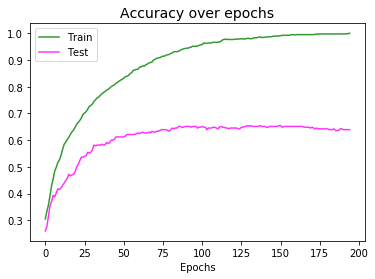

Confusion matrix, without normalization
[[52  5  5  8  4]
 [ 3 37  3 11  7]
 [ 0 10 40  3  3]
 [ 6  5 11 46  7]
 [ 4  8  5 11 36]]


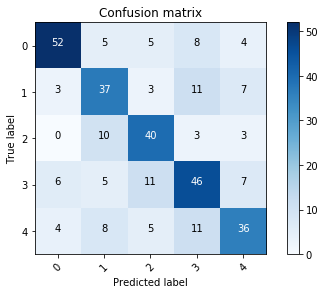

In [169]:
mlp_0, preds_0,data_0, train_scores_0, validation_scores_0 = mlperc(max_iter = 195)

We get a validation score of 0.639394

## Standardization

MLP is sensitive to unscaled features, we should standardize our feature columns.
Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distrbution, which makes it easier to learn the weights. 

We still use parse_data which splits the dataset and then normalizes the data if Normalize = True.

nc=33
Epoch = 0, Loss = 1.66395, Training score = 0.297403, Validation score = 0.248485
Epoch = 1, Loss = 1.58894, Training score = 0.333766, Validation score = 0.281818
Epoch = 2, Loss = 1.52782, Training score = 0.364935, Validation score = 0.30303
Epoch = 3, Loss = 1.47429, Training score = 0.383117, Validation score = 0.345455
Epoch = 4, Loss = 1.42754, Training score = 0.419481, Validation score = 0.369697
Epoch = 5, Loss = 1.38757, Training score = 0.455844, Validation score = 0.384848
Epoch = 6, Loss = 1.35175, Training score = 0.483117, Validation score = 0.381818
Epoch = 7, Loss = 1.3178, Training score = 0.492208, Validation score = 0.393939
Epoch = 8, Loss = 1.2872, Training score = 0.503896, Validation score = 0.418182
Epoch = 9, Loss = 1.25874, Training score = 0.518182, Validation score = 0.427273
Epoch = 10, Loss = 1.23297, Training score = 0.52987, Validation score = 0.430303
Epoch = 11, Loss = 1.20852, Training score = 0.544156, Validation score = 0.439394
Epoch = 12, 

C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch = 23, Loss = 0.986251, Training score = 0.658442, Validation score = 0.515152
Epoch = 24, Loss = 0.970947, Training score = 0.661039, Validation score = 0.527273
Epoch = 25, Loss = 0.956512, Training score = 0.667532, Validation score = 0.533333
Epoch = 26, Loss = 0.941731, Training score = 0.67013, Validation score = 0.542424
Epoch = 27, Loss = 0.92736, Training score = 0.672727, Validation score = 0.539394
Epoch = 28, Loss = 0.913567, Training score = 0.680519, Validation score = 0.539394
Epoch = 29, Loss = 0.899553, Training score = 0.688312, Validation score = 0.542424
Epoch = 30, Loss = 0.885927, Training score = 0.693506, Validation score = 0.548485
Epoch = 31, Loss = 0.872401, Training score = 0.705195, Validation score = 0.557576
Epoch = 32, Loss = 0.859344, Training score = 0.707792, Validation score = 0.560606
Epoch = 33, Loss = 0.846824, Training score = 0.712987, Validation score = 0.563636
Epoch = 34, Loss = 0.833976, Training score = 0.719481, Validation score = 0.5

Epoch = 146, Loss = 0.205853, Training score = 0.976623, Validation score = 0.648485
Epoch = 147, Loss = 0.203457, Training score = 0.976623, Validation score = 0.651515
Epoch = 148, Loss = 0.201383, Training score = 0.979221, Validation score = 0.648485
Epoch = 149, Loss = 0.198926, Training score = 0.979221, Validation score = 0.651515
Epoch = 150, Loss = 0.196574, Training score = 0.979221, Validation score = 0.651515
Epoch = 151, Loss = 0.194554, Training score = 0.979221, Validation score = 0.651515
Epoch = 152, Loss = 0.192291, Training score = 0.979221, Validation score = 0.651515
Epoch = 153, Loss = 0.190094, Training score = 0.979221, Validation score = 0.648485
Epoch = 154, Loss = 0.18804, Training score = 0.980519, Validation score = 0.651515
Epoch = 155, Loss = 0.185856, Training score = 0.980519, Validation score = 0.651515
Epoch = 156, Loss = 0.183874, Training score = 0.981818, Validation score = 0.654545
Epoch = 157, Loss = 0.181776, Training score = 0.981818, Validatio

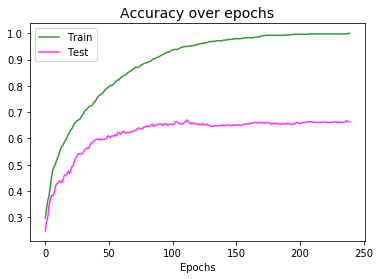

Confusion matrix, without normalization
[[53  4  6  8  3]
 [ 2 38  4 11  6]
 [ 0 10 40  3  3]
 [ 5  4 10 49  7]
 [ 5  7  5  8 39]]


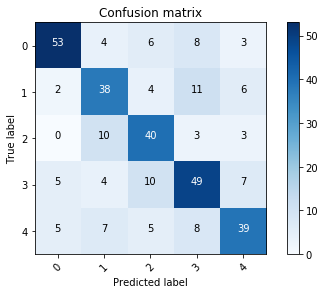

In [175]:
mlp_1,preds_1, data_1, train_scores_1, validation_scores_1 = mlperc(normalize = True,max_iter = 240)

If we compare this and the previous confusion matrix we can observe a slight improvement.
We achieved Validation score = 0.663636

## Improving learning: hyperparameters tuning

I implement a grid search combined with cross validation (RandomSearchCV) to find ideal values for the hyper parameters of the MLP, such as hidden layer structure, activation functions, method
of minimisation (i.e. gradient descent), regularisation constant, batch size ecc..  


In [176]:
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

In [177]:
from sklearn.cross_validation import StratifiedKFold

### Alpha, Batch and ...
We have to take into account a number of things:  
- **alpha**: i.e.Regularization - it isn't just about controlling over-fitting. By introducing some stochastic process into the training procedure you are in some sense "smoothing" out the cost landscape. This can speed up training, help deal with outliers in the data, and prevent extreme weight configurations of the network.   
- **batch_size**: using too large a batch size can have a negative effect on the accuracy of your network during training since it reduces the stochasticity of the gradient descent.  
- **learning_rate_init**:   
- **activation**: Using an activation function on the final layer can sometimes mean that your network cannot produce the full range of required values. The most common error is using a ReLU on the final layer - resulting in a network can only produce positive values as output.
- **solver**: 'adam'

In [251]:
import random
def change_all(num_train = 770, num_test = 330, normalize = True, n_components = 0,seed = 246232, **mlp_params):
    data = parse_data(num_train, num_test, normalize, seed)
    # prepare a uniform distribution to sample for the alpha parameter
    param_distributions = {'alpha' : uniform(1e-6, 1e-1), 
                           'batch_size' : randint(10, 200),
                           'learning_rate_init' : uniform(1e-6, 1e-1),
                           'hidden_layer_sizes' : [ ( random.randint(1, 200), random.randint(1, 100) ) for k in range(10)],
                           'activation' : ['identity', 'logistic', 'tanh', 'relu'],   
                           'learning_rate' : ['constant', 'invscaling', 'adaptive'],
                           'solver' : ['lbfgs', 'sgd', 'adam'],
                          }
    
    # create and fit a mlp model, testing random alpha values
    model = MLPClassifier(**mlp_params)
    n_search_iter = 4
    rs = RandomizedSearchCV(estimator = model, n_iter = n_search_iter, param_distributions = param_distributions, cv = 10)
    rs.fit(*data.train())
    
    # evaluate the best randomized searched model on the testing data
    acc = rs.score(*data.test())
    print("accuracy: {:.2f}%".format(acc * 100))
    print("randomized search best parameters: {}".format(rs.best_params_))
    
    
    return rs.best_params_

In [252]:
change_all()

nc=33
accuracy: 64.85%
randomized search best parameters: {'activation': 'logistic', 'alpha': 0.04569881292381367, 'batch_size': 130, 'hidden_layer_sizes': (142, 71), 'learning_rate': 'adaptive', 'learning_rate_init': 0.043294850873416307, 'solver': 'lbfgs'}


{'activation': 'logistic',
 'alpha': 0.04569881292381367,
 'batch_size': 130,
 'hidden_layer_sizes': (142, 71),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.043294850873416307,
 'solver': 'lbfgs'}

 
accuracy: 64.85%  
randomized search best parameters: {'activation': 'logistic', 'alpha': 0.04569881292381367, 'batch_size': 130, 'hidden_layer_sizes': (142, 71), 'learning_rate': 'adaptive', 'learning_rate_init': 0.043294850873416307, 'solver': 'lbfgs'}  



nc=33
Epoch = 0, Loss = 1.60789, Training score = 0.233766, Validation score = 0.184848
Epoch = 1, Loss = 1.60726, Training score = 0.233766, Validation score = 0.184848
Epoch = 2, Loss = 1.60446, Training score = 0.233766, Validation score = 0.184848
Epoch = 3, Loss = 1.60288, Training score = 0.233766, Validation score = 0.184848
Epoch = 4, Loss = 1.59412, Training score = 0.233766, Validation score = 0.184848
Epoch = 5, Loss = 1.58225, Training score = 0.233766, Validation score = 0.184848
Epoch = 6, Loss = 1.5414, Training score = 0.261039, Validation score = 0.224242
Epoch = 7, Loss = 1.42048, Training score = 0.375325, Validation score = 0.354545
Epoch = 8, Loss = 1.29508, Training score = 0.466234, Validation score = 0.430303
Epoch = 9, Loss = 1.22025, Training score = 0.506494, Validation score = 0.436364
Epoch = 10, Loss = 1.14885, Training score = 0.533766, Validation score = 0.463636
Epoch = 11, Loss = 1.03455, Training score = 0.596104, Validation score = 0.487879
Epoch = 1

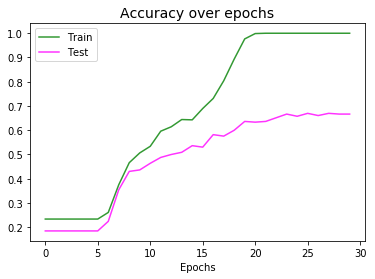

Confusion matrix, without normalization
[[59  5  3  6  1]
 [ 2 39  7  6  7]
 [ 0 13 35  4  4]
 [ 4  5  9 52  5]
 [ 6  9  9  5 35]]
0:00:03


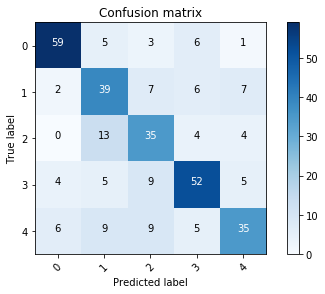

In [254]:
import time
from datetime import timedelta

start_time = time.monotonic()
t_mlp, tpreds,tdata, ttrain_scores, tvalidation_scores = mlperc(normalize = True,max_iter = 30,
                                                               solver = 'lbfgs',
                                                               activation = 'logistic',
                                                               alpha = 0.04569881292381367, 
                                                               batch_size = 130,
                                                               hidden_layer_sizes = (142, 71),
                                                               learning_rate = 'adaptive', 
                                                               learning_rate_init = 0.043294850873416307)
end_time = time.monotonic()
print(timedelta(seconds = end_time - start_time))

After choosing the best parameters for our classification problem, we observe that learning rate has increased, but the achieved validation score is now 0.66

Tuning those params did improve test accuracy but it was almost unnoticeable. So we go further...

## Feature selection

Feature subset selection is the process of identifying and removing as much irrelevant and redundant information as possible.  
This reduces the dimensionality of the data and may allow learning algorithms to operate faster and more effectively.  
In some cases, accuracy on future classification can be improved; in others, the result is a more compact, easily interpreted representation of the target concept.

### PCA

nc=8
Epoch = 0, Loss = 1.60997, Training score = 0.233766, Validation score = 0.184848
Epoch = 1, Loss = 1.60935, Training score = 0.233766, Validation score = 0.184848
Epoch = 2, Loss = 1.60591, Training score = 0.233766, Validation score = 0.184848
Epoch = 3, Loss = 1.60383, Training score = 0.233766, Validation score = 0.184848
Epoch = 4, Loss = 1.57341, Training score = 0.194805, Validation score = 0.230303
Epoch = 5, Loss = 1.54628, Training score = 0.22987, Validation score = 0.284848
Epoch = 6, Loss = 1.47722, Training score = 0.298701, Validation score = 0.327273
Epoch = 7, Loss = 1.32149, Training score = 0.446753, Validation score = 0.418182
Epoch = 8, Loss = 1.23384, Training score = 0.479221, Validation score = 0.433333
Epoch = 9, Loss = 1.0981, Training score = 0.549351, Validation score = 0.478788
Epoch = 10, Loss = 1.01266, Training score = 0.596104, Validation score = 0.506061
Epoch = 11, Loss = 0.946528, Training score = 0.611688, Validation score = 0.542424
Epoch = 12

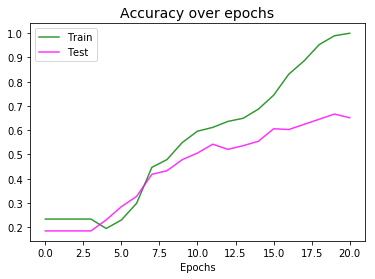

Confusion matrix, without normalization
[[54  5  4  6  5]
 [ 2 42  2  8  7]
 [ 1 11 33  8  3]
 [ 2  9  9 52  3]
 [ 4 10  6 10 34]]


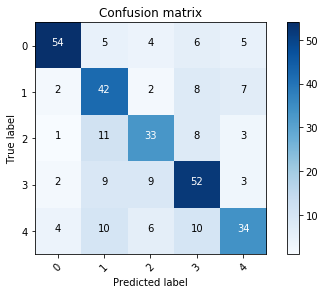

In [260]:
t1_mlp, t1_preds, t1_data, t1_train_scores, t1_validation_scores = mlperc(normalize = True,max_iter = 21,
                                                                          n_components = 8,
                                                                          solver = 'lbfgs', 
                                                                          activation = 'logistic',
                                                                          alpha = 0.04569881292381367, 
                                                                          batch_size = 130,
                                                                          hidden_layer_sizes = (142, 71),
                                                                          learning_rate = 'adaptive',  
                                                                          learning_rate_init = 0.043294850873416307)
                                                               

###### PCA did not help

## K Fold validation

In k-fold cross-validation, the data is randomly split into k mutually exclusive subsets of approximately equal size. A learning algorithm is trained and tested k times; each time it is tested on one of the k folds and trained using the remaining k − 1 folds.  
The cross-validation estimate of accuracy is the overall number of correct classifications, divided by the number of examples in the data.

In [261]:
def mlp_cv(features, target, n_splits = 10, **mlp_parameters):
    
    kfold = KFold(n_splits, shuffle = False) 
    train_scores = []
    validation_scores = []
    for train_index, validation_index in kfold.split(features):
        X_train, X_validation, y_train, y_validation = features[train_index], features[validation_index], target[train_index], \
                                                       target[validation_index]

        mlp = MLPClassifier(**mlp_parameters)
        
        probas_ = mlp.fit(X_train, y_train).predict_proba(X_validation)
        train_score = mlp.score(X_train, y_train)
        validation_score = mlp.score(X_validation, y_validation)
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        print("Training score = %g, Validation score = %g" % (train_score, validation_score))

    cv_score = np.mean(validation_scores)
    
    print("CV accuracy = %g" % (cv_score))
    return cv_score

In [264]:
cv_score1 = mlp_cv(features = features_1, 
                   target = target, 
                   solver = 'lbfgs', 
                   activation = 'logistic',
                   alpha = 0.04569881292381367, 
                   batch_size = 130,
                   hidden_layer_sizes = (142, 71),
                   learning_rate = 'adaptive',  
                   learning_rate_init = 0.043294850873416307
                  )

Training score = 1, Validation score = 0.718182
Training score = 1, Validation score = 0.672727
Training score = 1, Validation score = 0.718182
Training score = 1, Validation score = 0.7
Training score = 1, Validation score = 0.709091
Training score = 1, Validation score = 0.618182
Training score = 1, Validation score = 0.654545
Training score = 1, Validation score = 0.654545
Training score = 1, Validation score = 0.6
Training score = 1, Validation score = 0.645455
CV accuracy = 0.669091


In [265]:
d['MLP'] = cv_score1

# Random forest

Random forest is not affected by feature scaling, so we do not use normalized data. 
Also I found http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [266]:
def random_f(num_train = 770, num_test = 330, seed = 246232, feat_imp = True, **xtrees_params):
    
    data = parse_data(num_train, num_test, seed)
    
    clf = ExtraTreesClassifier(**xtrees_params)
    clf.fit(*data.train())
    train_score = clf.score(*data.train())
    test_score = clf.score(*data.test())
    print("Final training score = %g, validation score = %g" % (train_score, test_score))
    
    if feat_imp:
        imp = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
        indices = np.argsort(imp)[::-1]
        print("Feature ranking:")
        fe, ta = data.train()
        for f in range(fe.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f]+1, imp[indices[f]]))
        
        # Plot the feature importances of the forest
        plt.figure(figsize = (12,6))    
        plt.title("Feature importances")
        plt.bar(range(fe.shape[1]), imp[indices], color='b', align="center")
        plt.xticks(range(fe.shape[1]), indices + 1)
        plt.xlim([-1, fe.shape[1]])
        
        plt.show()
        return train_score, test_score
    
    return clf

nc=33
Final training score = 1, validation score = 0.533333
Feature ranking:
1. feature 32 (0.086084)
2. feature 33 (0.055796)
3. feature 31 (0.045045)
4. feature 11 (0.042097)
5. feature 27 (0.041669)
6. feature 16 (0.037014)
7. feature 17 (0.033997)
8. feature 9 (0.033331)
9. feature 24 (0.032551)
10. feature 1 (0.031530)
11. feature 2 (0.031511)
12. feature 28 (0.030767)
13. feature 7 (0.030604)
14. feature 21 (0.030109)
15. feature 19 (0.026833)
16. feature 3 (0.026123)
17. feature 23 (0.025373)
18. feature 30 (0.025131)
19. feature 4 (0.024973)
20. feature 5 (0.024851)
21. feature 6 (0.024429)
22. feature 22 (0.024376)
23. feature 29 (0.023899)
24. feature 8 (0.023017)
25. feature 18 (0.022700)
26. feature 13 (0.022169)
27. feature 14 (0.021792)
28. feature 26 (0.021070)
29. feature 12 (0.020881)
30. feature 15 (0.020491)
31. feature 10 (0.020296)
32. feature 25 (0.020053)
33. feature 20 (0.019435)


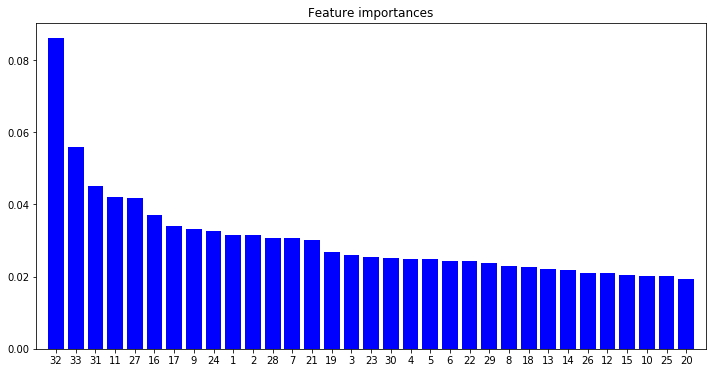

In [267]:
clf = random_f()

?

In [268]:
def rf_hyp(num_train = 770, num_test = 330, n_components = 0, seed = 246232):
    data = parse_data(num_train, num_test, n_components, seed)

    param_distributions ={'n_estimators' : randint(1,300),
                          'criterion' :['gini','entropy'],
                          'max_depth' : randint(1,80), 
                          'min_samples_split' : randint(2,80),
                          'min_samples_leaf' : randint(1,80),
                         }
    
    
    n_search_iter = 5
    model = ExtraTreesClassifier()
    rCV = RandomizedSearchCV(model, param_distributions, n_search_iter, cv = 5)
    rCV.fit(*data.train())
    
    # evaluate the best randomized searched model on the testing data
    acc = rCV.score(*data.test())
    print("grid search accuracy: {:.2f}%".format(acc * 100))
    print("randomized search best parameters: {}".format(rCV.best_params_))
    
    
    return rCV.best_params_

In [269]:
rf_hyp()

nc=33
grid search accuracy: 55.15%
randomized search best parameters: {'criterion': 'gini', 'max_depth': 48, 'min_samples_leaf': 18, 'min_samples_split': 22, 'n_estimators': 167}


{'criterion': 'gini',
 'max_depth': 48,
 'min_samples_leaf': 18,
 'min_samples_split': 22,
 'n_estimators': 167}

{'criterion': 'gini', 'max_depth': 48, 'min_samples_leaf': 18, 'min_samples_split': 22, 'n_estimators': 167}

In [270]:
clf_2 = random_f(feat_imp = False, criterion = 'gini', 
                 n_estimators = 167, max_depth = 48, 
                 min_samples_leaf = 10, min_samples_split =22)

nc=33
Final training score = 0.674026, validation score = 0.527273


In [271]:
def xtree_cv(features, target, n_splits = 10, **xtc_parameters):
    
    kfold = KFold(n_splits, shuffle = False) 
    train_scores = []
    validation_scores = []
    for train_index, validation_index in kfold.split(features):
        X_train, X_validation, y_train, y_validation = features[train_index], features[validation_index], target[train_index], \
                                                       target[validation_index]

        xtc = ExtraTreesClassifier(**xtc_parameters)
        
        probas_ = xtc.fit(X_train, y_train).predict_proba(X_validation)
        train_score = xtc.score(X_train, y_train)
        validation_score = xtc.score(X_validation, y_validation)
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        print("Training score = %g, Validation score = %g" % (train_score, validation_score))
        
    cvscore = np.mean(validation_scores)
    print("CV accuracy = %g" % (cvscore))
    
    return cvscore

In [272]:
cvscore = xtree_cv(features_1, 
                   target_1, 
                   criterion = 'gini', 
                   max_depth = 48, 
                   min_samples_leaf = 18, 
                   min_samples_split = 22, 
                   n_estimators = 167)

Training score = 0.626263, Validation score = 0.527273
Training score = 0.647475, Validation score = 0.545455
Training score = 0.659596, Validation score = 0.545455
Training score = 0.646465, Validation score = 0.518182
Training score = 0.640404, Validation score = 0.563636
Training score = 0.634343, Validation score = 0.472727
Training score = 0.663636, Validation score = 0.518182
Training score = 0.640404, Validation score = 0.6
Training score = 0.657576, Validation score = 0.554545
Training score = 0.647475, Validation score = 0.6
CV accuracy = 0.544545


In [273]:
d['extree'] = cvscore

## Further Analysis

In [275]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [276]:
def other_m(num_train = 770, num_test = 330, seed = 246232, max_iter = 200):
    
    data = parse_data(num_train, num_test, seed)
    
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('SGD', SGDClassifier()))
    # evaluate each model in turn
    names = []    
    train_scores = []
    validation_scores = []
    for name, model in models:
        model.fit(*data.train())
        train_score = model.score(*data.train())
        validation_score = model.score(*data.test())
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        names.append(name)
        print("%s: %f (%f)" % (name, train_score, validation_score))

    return train_scores, validation_scores

In [277]:
other_m()

nc=33
KNN: 0.745455 (0.627273)
NB: 0.381818 (0.369697)
SVM: 0.880519 (0.654545)
SGD: 0.423377 (0.354545)


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


([0.74545454545454548,
  0.38181818181818183,
  0.88051948051948048,
  0.42337662337662335],
 [0.62727272727272732,
  0.36969696969696969,
  0.65454545454545454,
  0.35454545454545455])

We will start to implemet SVM

In [292]:
def svm_hyp_1(num_train = 770, num_test = 330, seed = 246232):
    data = parse_data(num_train, num_test, seed)

    param_distributions ={'C' : uniform(0,50), 
                          'degree' : randint(1,100),
                          'gamma' : uniform(0,50),
                          'coef0' : uniform(0,50),
                          'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                          'decision_function_shape' : ['ovo', 'ovr'],
                         }
    
    
    # create and fit a SVM model.
    n_search_iter = 10
    model = SVC()
    rCV = RandomizedSearchCV(model, param_distributions, n_search_iter)
    rCV.fit(*data.train())
    
    rbest_params = rCV.best_params_
    rvalidation_accuracy = rCV.score(*data.test())
    print('Validation accuracy: ', rvalidation_accuracy)
    print('The best parameters are:', rCV.best_estimator_)    
    return rbest_params

In [293]:
svm_hyp_1()

nc=33
Validation accuracy:  0.481818181818
The best parameters are: SVC(C=46.866768547209332, cache_size=200, class_weight=None,
  coef0=17.719425530689847, decision_function_shape='ovr', degree=51,
  gamma=20.188112635063721, kernel='linear', max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)


{'C': 46.866768547209332,
 'coef0': 17.719425530689847,
 'decision_function_shape': 'ovr',
 'degree': 51,
 'gamma': 20.188112635063721,
 'kernel': 'linear'}

In [296]:
def svm_one(num_train = 770, num_test = 330, seed = 246232, max_it = 130, n_components = 0, **svc_params):
    
    data = parse_data(num_train, num_test, seed, n_components)
    svc = SVC(**svc_params)
    
    train_scores = []
    validation_scores = []
    for epoch in range(max_it):      
        svc.set_params(max_iter = epoch + 1)
        svc.fit(*data.train())
        train_score = svc.score(*data.train())
        validation_score = svc.score(*data.test())
        print("epoch = %g, tscore = %g, vscore = %g" % (epoch, train_score, validation_score))
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        
    preds = svc.predict(X_test)
    
    
    plt.figure(figsize = (data.test()[0])
    plt.plot(train_scores)
    plt.plot(validation_scores)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    
    return svc, train_scores, validation_scores

nc=33
epoch = 0, tscore = 0.192208, vscore = 0.172727
epoch = 1, tscore = 0.263636, vscore = 0.278788
epoch = 2, tscore = 0.271429, vscore = 0.257576
epoch = 3, tscore = 0.346753, vscore = 0.278788
epoch = 4, tscore = 0.287013, vscore = 0.281818
epoch = 5, tscore = 0.390909, vscore = 0.381818
epoch = 6, tscore = 0.348052, vscore = 0.290909
epoch = 7, tscore = 0.406494, vscore = 0.357576
epoch = 8, tscore = 0.336364, vscore = 0.336364
epoch = 9, tscore = 0.367532, vscore = 0.333333
epoch = 10, tscore = 0.338961, vscore = 0.3
epoch = 11, tscore = 0.337662, vscore = 0.309091
epoch = 12, tscore = 0.357143, vscore = 0.318182
epoch = 13, tscore = 0.345455, vscore = 0.3
epoch = 14, tscore = 0.37013, vscore = 0.321212
epoch = 15, tscore = 0.405195, vscore = 0.342424
epoch = 16, tscore = 0.37013, vscore = 0.345455
epoch = 17, tscore = 0.361039, vscore = 0.290909

C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\s


epoch = 18, tscore = 0.402597, vscore = 0.327273
epoch = 19, tscore = 0.346753, vscore = 0.327273
epoch = 20, tscore = 0.374026, vscore = 0.348485
epoch = 21, tscore = 0.384416, vscore = 0.363636
epoch = 22, tscore = 0.380519, vscore = 0.336364
epoch = 23, tscore = 0.4, vscore = 0.351515
epoch = 24, tscore = 0.375325, vscore = 0.357576
epoch = 25, tscore = 0.362338, vscore = 0.3
epoch = 26, tscore = 0.37013, vscore = 0.375758
epoch = 27, tscore = 0.392208, vscore = 0.39697
epoch = 28, tscore = 0.407792, vscore = 0.4


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=30).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=31).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=32).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=33).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 29, tscore = 0.423377, vscore = 0.412121
epoch = 30, tscore = 0.353247, vscore = 0.369697
epoch = 31, tscore = 0.384416, vscore = 0.390909
epoch = 32, tscore = 0.396104, vscore = 0.421212
epoch = 33, tscore = 0.407792, vscore = 0.430303
epoch = 34, tscore = 0.411688, vscore = 0.415152
epoch = 35, tscore = 0.407792, vscore = 0.412121
epoch = 36, tscore = 0.409091, vscore = 0.384848
epoch = 37, tscore = 0.406494, vscore = 0.390909


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=39).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=41).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=42).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 38, tscore = 0.341558, vscore = 0.330303
epoch = 39, tscore = 0.384416, vscore = 0.315152
epoch = 40, tscore = 0.372727, vscore = 0.342424
epoch = 41, tscore = 0.376623, vscore = 0.363636
epoch = 42, tscore = 0.393506, vscore = 0.339394
epoch = 43, tscore = 0.406494, vscore = 0.393939
epoch = 44, tscore = 0.403896, vscore = 0.378788
epoch = 45, tscore = 0.431169, vscore = 0.393939
epoch = 46, tscore = 0.35974, vscore = 0.309091


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=47).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=48).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=49).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 47, tscore = 0.372727, vscore = 0.339394
epoch = 48, tscore = 0.379221, vscore = 0.339394
epoch = 49, tscore = 0.419481, vscore = 0.409091
epoch = 50, tscore = 0.407792, vscore = 0.330303
epoch = 51, tscore = 0.428571, vscore = 0.381818
epoch = 52, tscore = 0.407792, vscore = 0.39697
epoch = 53, tscore = 0.363636, vscore = 0.336364
epoch = 54, tscore = 0.431169, vscore = 0.39697


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=55).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=56).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=57).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=58).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 55, tscore = 0.396104, vscore = 0.4
epoch = 56, tscore = 0.41039, vscore = 0.387879
epoch = 57, tscore = 0.402597, vscore = 0.387879
epoch = 58, tscore = 0.381818, vscore = 0.375758
epoch = 59, tscore = 0.412987, vscore = 0.366667
epoch = 60, tscore = 0.431169, vscore = 0.409091
epoch = 61, tscore = 0.388312, vscore = 0.393939
epoch = 62, tscore = 0.407792, vscore = 0.351515


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=63).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=64).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=65).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=66).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 63, tscore = 0.445455, vscore = 0.4
epoch = 64, tscore = 0.425974, vscore = 0.345455
epoch = 65, tscore = 0.445455, vscore = 0.433333
epoch = 66, tscore = 0.333766, vscore = 0.360606
epoch = 67, tscore = 0.451948, vscore = 0.415152
epoch = 68, tscore = 0.419481, vscore = 0.372727


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=71).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=72).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=73).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 69, tscore = 0.377922, vscore = 0.360606
epoch = 70, tscore = 0.38961, vscore = 0.40303
epoch = 71, tscore = 0.428571, vscore = 0.4
epoch = 72, tscore = 0.387013, vscore = 0.339394
epoch = 73, tscore = 0.394805, vscore = 0.393939
epoch = 74, tscore = 0.420779, vscore = 0.415152


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=76).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=77).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=78).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=79).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 75, tscore = 0.407792, vscore = 0.409091
epoch = 76, tscore = 0.362338, vscore = 0.327273
epoch = 77, tscore = 0.371429, vscore = 0.360606
epoch = 78, tscore = 0.424675, vscore = 0.387879
epoch = 79, tscore = 0.393506, vscore = 0.393939
epoch = 80, tscore = 0.422078, vscore = 0.415152
epoch = 81, tscore = 0.451948, vscore = 0.424242
epoch = 82, tscore = 0.412987, vscore = 0.393939
epoch = 83, tscore = 0.424675, vscore = 0.427273
epoch = 84, tscore = 0.403896, vscore = 0.390909
epoch = 85, tscore = 0.418182, vscore = 0.345455
epoch = 86, tscore = 0.403896, vscore = 0.4
epoch = 87, tscore = 0.388312, vscore = 0.378788


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=83).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=84).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=85).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=86).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 88, tscore = 0.37013, vscore = 0.345455
epoch = 89, tscore = 0.423377, vscore = 0.418182
epoch = 90, tscore = 0.437662, vscore = 0.366667
epoch = 91, tscore = 0.394805, vscore = 0.351515
epoch = 92, tscore = 0.387013, vscore = 0.360606
epoch = 93, tscore = 0.392208, vscore = 0.354545


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=90).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=91).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=92).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=93).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 94, tscore = 0.422078, vscore = 0.390909
epoch = 95, tscore = 0.405195, vscore = 0.439394
epoch = 96, tscore = 0.415584, vscore = 0.4
epoch = 97, tscore = 0.405195, vscore = 0.418182
epoch = 98, tscore = 0.358442, vscore = 0.357576
epoch = 99, tscore = 0.477922, vscore = 0.457576


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=96).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=97).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=98).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=99).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklea

epoch = 100, tscore = 0.409091, vscore = 0.436364
epoch = 101, tscore = 0.44026, vscore = 0.378788
epoch = 102, tscore = 0.388312, vscore = 0.360606
epoch = 103, tscore = 0.405195, vscore = 0.372727
epoch = 104, tscore = 0.409091, vscore = 0.366667
epoch = 105, tscore = 0.344156, vscore = 0.351515


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=102).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=103).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=104).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=105).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\s

epoch = 106, tscore = 0.422078, vscore = 0.409091
epoch = 107, tscore = 0.405195, vscore = 0.351515
epoch = 108, tscore = 0.424675, vscore = 0.384848
epoch = 109, tscore = 0.41039, vscore = 0.421212
epoch = 110, tscore = 0.403896, vscore = 0.354545
epoch = 111, tscore = 0.392208, vscore = 0.339394


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=108).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=109).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=110).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=111).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\s

epoch = 112, tscore = 0.41039, vscore = 0.387879
epoch = 113, tscore = 0.451948, vscore = 0.418182
epoch = 114, tscore = 0.457143, vscore = 0.390909
epoch = 115, tscore = 0.390909, vscore = 0.412121
epoch = 116, tscore = 0.435065, vscore = 0.406061


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=114).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=115).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=116).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=117).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\s

epoch = 117, tscore = 0.412987, vscore = 0.384848
epoch = 118, tscore = 0.407792, vscore = 0.351515
epoch = 119, tscore = 0.453247, vscore = 0.390909
epoch = 120, tscore = 0.405195, vscore = 0.409091
epoch = 121, tscore = 0.442857, vscore = 0.436364
epoch = 122, tscore = 0.406494, vscore = 0.393939


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=119).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=120).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=121).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=122).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\s

epoch = 123, tscore = 0.401299, vscore = 0.375758
epoch = 124, tscore = 0.374026, vscore = 0.378788
epoch = 125, tscore = 0.435065, vscore = 0.424242
epoch = 126, tscore = 0.416883, vscore = 0.357576
epoch = 127, tscore = 0.406494, vscore = 0.409091
epoch = 128, tscore = 0.412987, vscore = 0.421212


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=125).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=126).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=127).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=128).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\a_mon\Anaconda3\lib\site-packages\s

epoch = 129, tscore = 0.405195, vscore = 0.40303


C:\Users\a_mon\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=130).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


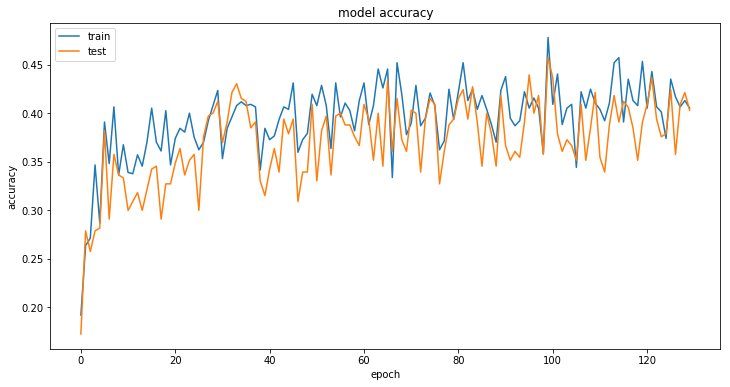

In [302]:
svc, tscore_svc, vscore_svc = svm_one(C = 300, 
                                      coef0 = 50, 
                                      decision_function_shape = 'ovo', 
                                      degree = 51,
                                      gamma = 20.188112635063721, 
                                      kernel = 'linear',
                                     )

We can try to implement the KNN

In [ ]:
def knn_hyp_1(num_train = 770, num_test = 330, seed = 246232):
    data = parse_data(num_train, num_test, seed)

    # prepare a a grid with possible values for the parameters
    parameters = {'n_neighbors' : [1,2,3,4,5,6,7,8,9],
                  'weights' : ['uniform', 'distance'], 
                  'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p' : [1, 2, 3], #distance
                 }
    
    # create and fit a SVM model.
    model = KNeighborsClassifier()
    gridCV = GridSearchCV(model, parameters)
    gridCV.fit(*data.train())
    
    best_params = gridCV.best_params_
    validation_accuracy = gridCV.score(*data.test())

    print('Validation accuracy: ', validation_accuracy)
    print('The best parameters are:', best_params)    
    return best_params

In [ ]:
def knn_hyp_2(num_train = 770, num_test = 330, seed = 246232):
    data = parse_data(num_train, num_test, seed)

    param_distributions ={'n_neighbors' : randint(0,20), 
                          'degree' : randint(1,10),
                          'leaf_size' : randint(1,50),
                         }
    
    
    # create and fit a SVM model.
    n_search_iter = 10
    model = KNeighborsClassifier()
    rCV = RandomizedSearchCV(model, param_distributions, n_search_iter)

    rCV.fit(*data.train())
    rbest_params = rCV.best_params_
    rvalidation_accuracy = rCV.score(*data.test())
    print('Validation accuracy: ', rvalidation_accuracy)
    print('The best parameters are:', rbest_params)    
    return rbest_params

In [ ]:
knn_hyp_1()

In [ ]:
def knn_(num_train = 770, num_test = 330, seed = 246232, **knn_params):
    
    data = parse_data(num_train, num_test, seed)
    knn = KNeighborsClassifier(**knn_params)
    max_iter = knn_params.pop('max_iter')
    
    train_scores = []
    validation_scores = []
    for epoch in range(max_iter):      
        knn.set_params(max_iter = epoch + 1)
        knn.fit(*data.train())
        train_score = knn.score(*data.train())
        validation_score = knn.score(*data.test())
        loss = knn.loss_
        print("Epoch = %g, Loss = %g" % (epoch, loss))
        print("   Training accuracy = %g, validation accuracy %g" % (train_score, validation_score))
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        knn.set_params(warm_start = True)
        X_train, y_train = data.train()
        X_test, y_test = data.test()
    
    return mlp,X_train, y_train ,X_test, y_test, train_scores, validation_scores

In [ ]:
knn_(algorithm = 'auto', p = 2, weights = 'distance')

In [ ]:
def find_optimal_k(relevent_X, plot=False):
    '''
    optimize k for knn
    :param relevent_X: the training set 
    :param plot: should be plotted?
    :return: auc and optimal k
    '''
    # creating odd list of K for KNN
    neighbors = list(range(1, 25, 5))  # subsetting just the odd ones

    # empty list that will hold cv scores
    cv_auc = []

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")  # calculate knn for k neighbors
        cv_auc.append(evaluate_auc_roc(relevent_X, y, knn))  # append to the list of auc
    # changing to misclassification error
    # determining best k
    optimal_k = neighbors[cv_auc.index(max(cv_auc))]
    # from sklearn import neighbors, datasets
    clf = KNeighborsClassifier(n_neighbors=optimal_k,
                               weights="uniform",
                               metric="euclidean",
                               algorithm="brute")
    clf.fit(relevent_X, y)
    if plot:
        plt.plot(neighbors, cv_auc, linestyle='--', marker='o')
        plt.title('auc as a function of k')
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Auc')
        plt.show()
        print
        "The optimal number of neighbors is %d" % optimal_k
        return
    return evaluate_auc_roc(relevent_X, y, clf), optimal_k


# Conclusions

In [303]:
d 

{'MLP': 0.66909090909090907, 'extree': 0.54454545454545455}

MLP has a higher cross validation score than random forest